# Model Development with Undersampling on Alzheimer Disease Classification

Name: Anthony Kevin Oktavius

In [1]:
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.6 MB/s eta 0:00:00


Library Import

In [2]:
import numpy as np
import zipfile
import gc
import cv2
import math
import warnings
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import torch
import torchvision
import torchvision.transforms as transforms

import torch.optim as optim
import torch.nn as nn
# import torchmetrics
import torch.nn.functional as F
import PIL
import torch.utils.data as data_utils
import json
import pickle

# import pytorch_lightning as pl
import imutils
import zipfile

from torchvision.transforms import v2
from tqdm import tqdm
from torch.utils.data import Dataset, BatchSampler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python.client import device_lib
from zipfile import ZipFile
from IPython import display
from torchvision import models, transforms
from google.colab.patches import cv2_imshow
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.preprocessing import LabelEncoder
from torchvision.models.feature_extraction import create_feature_extractor
from datasets import load_dataset
from PIL import Image
from collections import defaultdict
from torchvision.ops import DropBlock2d
from google.colab import drive
from datetime import datetime
from operator import itemgetter
from sklearn.metrics import ConfusionMatrixDisplay
from torch.utils.data import default_collate
from sklearn import metrics
from torch.optim.lr_scheduler import StepLR
from imblearn.under_sampling import NeighbourhoodCleaningRule

Check if there is a GPU installed.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Print the specification of the device.

In [4]:
print("Device Specifications:")
print(device_lib.list_local_devices())

Device Specifications:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 873481568728977099
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7511805203181081580
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
! cp ./drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
! kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images
! unzip -qq alzheimers-dataset-4-class-of-images.zip

 64% 22.0M/34.1M [00:00<00:00, 97.3MB/s]
100% 34.1M/34.1M [00:00<00:00, 118MB/s] 


## Data Preparation

In [10]:
alzheimer_train_image_folders = torchvision.datasets.ImageFolder(
    "Alzheimer_s Dataset/train",
)

alzheimer_val_image_folders = torchvision.datasets.ImageFolder(
    "Alzheimer_s Dataset/test",
)

print(alzheimer_train_image_folders)
print(alzheimer_val_image_folders)

number_of_samples_per_classes = defaultdict(int)
for _, class_index in alzheimer_train_image_folders:
  number_of_samples_per_classes[class_index] += 1

print(number_of_samples_per_classes)
print(alzheimer_val_image_folders.imgs)

Dataset ImageFolder
    Number of datapoints: 5121
    Root location: Alzheimer_s Dataset/train
Dataset ImageFolder
    Number of datapoints: 1279
    Root location: Alzheimer_s Dataset/test
defaultdict(<class 'int'>, {0: 717, 1: 52, 2: 2560, 3: 1792})
[('Alzheimer_s Dataset/test/MildDemented/26 (19).jpg', 0), ('Alzheimer_s Dataset/test/MildDemented/26 (20).jpg', 0), ('Alzheimer_s Dataset/test/MildDemented/26 (21).jpg', 0), ('Alzheimer_s Dataset/test/MildDemented/26 (22).jpg', 0), ('Alzheimer_s Dataset/test/MildDemented/26 (23).jpg', 0), ('Alzheimer_s Dataset/test/MildDemented/26 (24).jpg', 0), ('Alzheimer_s Dataset/test/MildDemented/26 (25).jpg', 0), ('Alzheimer_s Dataset/test/MildDemented/26 (26).jpg', 0), ('Alzheimer_s Dataset/test/MildDemented/26 (27).jpg', 0), ('Alzheimer_s Dataset/test/MildDemented/26 (28).jpg', 0), ('Alzheimer_s Dataset/test/MildDemented/26.jpg', 0), ('Alzheimer_s Dataset/test/MildDemented/27 (10).jpg', 0), ('Alzheimer_s Dataset/test/MildDemented/27 (11).jpg', 0

In [11]:
baseline_train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((176, 176)),
])

In [12]:
class AlzheimerDiseaseDataset(Dataset):
  def __init__(self, image_folders, transform = None):
    super(AlzheimerDiseaseDataset, self).__init__()
    self.image_folders = image_folders
    self.transform = transform

  def __getitem__(self, item_index):
    image, class_index = self.image_folders[item_index]
    # image = np.array(image).astype(np.float64)

    class_index = torch.tensor(class_index)

    if self.transform is not None:
      image = self.transform(image)

    return image, class_index

  def __len__(self):
    return len(self.image_folders)

baseline_alzheimer_disease_train_dataset = AlzheimerDiseaseDataset(
  alzheimer_train_image_folders,
  transform = baseline_train_transform,
)

In [13]:
baseline_train_images = []
baseline_train_labels = []

for image, label in baseline_alzheimer_disease_train_dataset:
  baseline_train_images.append(np.array(image).reshape(-1))
  baseline_train_labels.append(label)

In [14]:
neighborhood_cleaning_rule = NeighbourhoodCleaningRule(
    sampling_strategy = 'auto',
    n_neighbors = 3,
    kind_sel = 'all',
    n_jobs = 4,
    threshold_cleaning = 0.5,
)

baseline_train_images_resampled, baseline_train_labels_resampled = neighborhood_cleaning_rule.fit_resample(
    baseline_train_images,
    baseline_train_labels
)

print(f"Number of train images after resampled: {len(baseline_train_images_resampled)}")

Number of train images after resampled: 5114


## Data Undersampling

Save each of the images into the undersampling folder.

In [15]:
classes = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]
try:
  os.mkdir("Undersampled_Dataset_Train")
except FileExistsError as e:
  pass

for image_class in classes:
  try:
    os.mkdir(f"Undersampled_Dataset_Train/{image_class}")
  except FileExistsError as e:
    pass

In [16]:
image_index = 0
for image_train, label_train in zip(baseline_train_images_resampled, baseline_train_labels_resampled):
  image_train = np.array(image_train)
  image_train = image_train
  image_train = image_train.astype(np.uint8)
  image_train = image_train.reshape(176, 176)
  image = Image.fromarray(image_train)
  image.save(f"Undersampled_Dataset_Train/{classes[label_train]}/{image_index}.jpg")
  image_index += 1

## Data Preparation After Undersampling

In [17]:
alzheimer_train_undersampled_image_folders = torchvision.datasets.ImageFolder(
    "Undersampled_Dataset_Train",
)

alzheimer_val_image_folders = torchvision.datasets.ImageFolder(
    "Alzheimer_s Dataset/test",
)

number_of_samples_per_classes_undersampled = defaultdict(int)
for _, class_index in alzheimer_train_undersampled_image_folders:
  number_of_samples_per_classes_undersampled[class_index] += 1

print(number_of_samples_per_classes_undersampled)

defaultdict(<class 'int'>, {0: 715, 1: 52, 2: 2558, 3: 1789})


In [18]:
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((176, 176)),
    # v2.RandomResizedCrop((176, 176), scale = (0.1, 1), ratio = (1, 1)),
    # transforms.RandomAdjustSharpness(sharpness_factor = 20, p = 1),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((176, 176)),
    # transforms.RandomAdjustSharpness(sharpness_factor = 10, p = 1),
    transforms.ToTensor(),
])

In [43]:
def collate_fn(batch):
  # alpha = random.uniform(0, 0.5)
  cutmix = v2.CutMix(num_classes = 4, alpha = 0.5)
  batch = cutmix(*default_collate(batch))
  # print(batch)
  return batch

# Assign the weight manually
sampler_weights = []

for class_index in number_of_samples_per_classes_undersampled:
  number_of_samples = number_of_samples_per_classes_undersampled[class_index]
  weight = 1 / number_of_samples
  print(f"Class index weight of class {class_index}: {weight}, num samples: {number_of_samples}")
  sampler_weights += ([weight] * number_of_samples)

weighted_random_sampler = torch.utils.data.sampler.WeightedRandomSampler(
    sampler_weights, len(sampler_weights)
)

batch_sampler = BatchSampler(
    weighted_random_sampler,
    batch_size = 16,
    drop_last = False,
)

alzheimer_disease_train_undersampled_dataset = AlzheimerDiseaseDataset(
  alzheimer_train_undersampled_image_folders,
  transform = train_transform,
)

alzheimer_disease_val_dataset = AlzheimerDiseaseDataset(
  alzheimer_val_image_folders,
  transform = val_transform,
)

alzheimer_train_undersampled_data_loader = torch.utils.data.DataLoader(
  alzheimer_disease_train_undersampled_dataset,
  collate_fn = collate_fn,
  batch_sampler = batch_sampler,
)

alzheimer_train_undersampled_data_loader_2 = torch.utils.data.DataLoader(
  alzheimer_disease_train_undersampled_dataset,
  batch_size = 16,
)

alzheimer_val_data_loader = torch.utils.data.DataLoader(
  alzheimer_disease_val_dataset,
  batch_size = 16,
  shuffle = False
)

Class index weight of class 0: 0.0013986013986013986, num samples: 715
Class index weight of class 1: 0.019230769230769232, num samples: 52
Class index weight of class 2: 0.00039093041438623924, num samples: 2558
Class index weight of class 3: 0.0005589714924538849, num samples: 1789


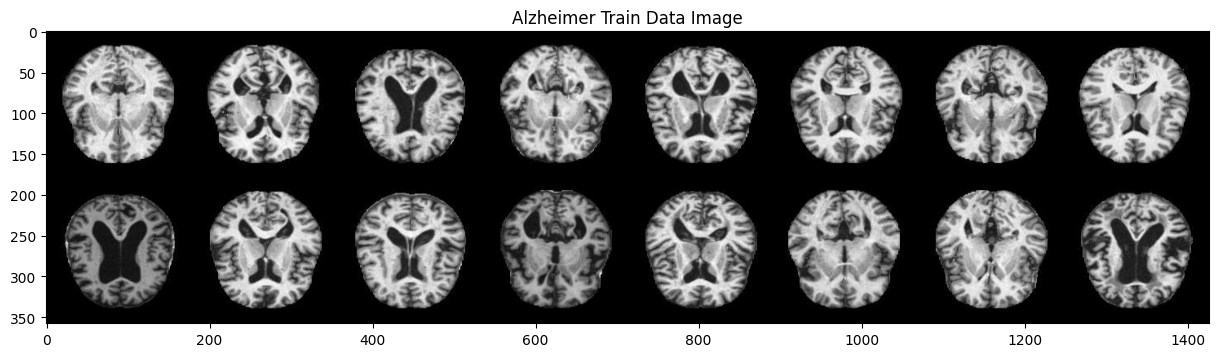

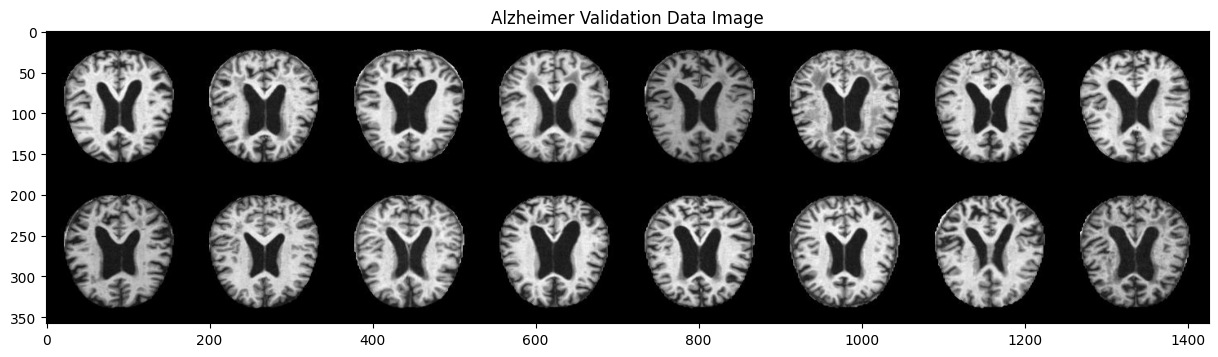

In [22]:
def visualize_pytorch_grid(images_in_batch, title):
  plt.figure(figsize = (15, 15))
  grid_images_in_batch = torchvision.utils.make_grid(images_in_batch)
  plt_compatible_grid_images_in_batch = np.transpose(grid_images_in_batch.numpy(), (1, 2, 0))
  plt.title(title)
  plt.imshow(plt_compatible_grid_images_in_batch)

def visualize_dataloader(data_loader, title):
  iter_loader = iter(data_loader)
  images_in_batch,  _ = next(iter_loader)

  visualize_pytorch_grid(images_in_batch, title)

visualize_dataloader(alzheimer_train_undersampled_data_loader, "Alzheimer Train Data Image")
visualize_dataloader(alzheimer_val_data_loader, "Alzheimer Validation Data Image")

## Building Custom Model

In [33]:
class AlzheimerDiseaseModel(nn.Module):
  def __init__(self, n_classes):
    super(AlzheimerDiseaseModel, self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1, bias = True),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1, bias = True),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        # nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1, bias = True),
        # nn.ReLU(),
        # nn.BatchNorm2d(32),
        nn.MaxPool2d(2,2)
    )

    # self.drop_block_1 = DropBlock2d(p = 0.9, block_size = 39)
    self.dropout = nn.Dropout(p = 0.6)

    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1, bias = True),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1, bias = True),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        # nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1, bias = True),
        # nn.ReLU(),
        # nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2)
    )

    # self.drop_block_2 = DropBlock2d(p = 0.9, block_size = 5)

    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1, bias = True),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        # nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1, bias = True),
        # nn.ReLU(),
        # nn.BatchNorm2d(128),
        # nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1, bias = True),
        # nn.ReLU(),
        # nn.BatchNorm2d(128),
        nn.MaxPool2d(2,2)
    )

    self.fc1 = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p = 0.5),
        nn.ReLU(),
        nn.Linear(61952, 512),
        nn.ReLU(),
    )
    self.fc2 = nn.Sequential(nn.Linear(512, n_classes))

  def forward(self, x):
    x = self.conv1(x)
    # x = self.drop_block_1(x)
    x = self.dropout(x)
    x = self.conv2(x)
    # x = self.drop_block_2(x)
    x = self.conv3(x)
    # x = self.conv4(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

alzheimer_disease_model = AlzheimerDiseaseModel(
    n_classes = 4
).to(device)

Visualize feature extraction information from the model layer, with a sample data.

In [34]:
def visualize_conv_weights(filters):
  number_of_filters = filters.shape[0]

  number_of_rows = math.ceil(number_of_filters / 32)
  number_of_columns = 32

  plt.figure(figsize = (80, number_of_rows * 2))
  border_in_string = "=" * 260
  plt.suptitle(f"{border_in_string}Convolutional Filters Visualization: {filters.shape}{border_in_string}")
  for index, filter in enumerate(filters):
    filter_weight = torch.sum(filter, dim = 0)

    plt.subplot(number_of_rows, number_of_columns, index + 1, label = f"Filter {index}")
    plt.imshow(filter_weight.cpu(), cmap = "gray")

  plt.tight_layout()
  plt.show()

def debug_model_weights(model_weights):
  print("Model Weights:")
  model_weight_keys = list(model_weights.keys())

  for weight_name in model_weights:
    print(f"{weight_name}: {model_weights[weight_name].shape}")

debug_model_weights(alzheimer_disease_model.state_dict())

Model Weights:
conv1.0.weight: torch.Size([32, 1, 3, 3])
conv1.0.bias: torch.Size([32])
conv1.2.weight: torch.Size([32])
conv1.2.bias: torch.Size([32])
conv1.2.running_mean: torch.Size([32])
conv1.2.running_var: torch.Size([32])
conv1.2.num_batches_tracked: torch.Size([])
conv1.3.weight: torch.Size([32, 32, 3, 3])
conv1.3.bias: torch.Size([32])
conv1.5.weight: torch.Size([32])
conv1.5.bias: torch.Size([32])
conv1.5.running_mean: torch.Size([32])
conv1.5.running_var: torch.Size([32])
conv1.5.num_batches_tracked: torch.Size([])
conv2.0.weight: torch.Size([64, 32, 3, 3])
conv2.0.bias: torch.Size([64])
conv2.2.weight: torch.Size([64])
conv2.2.bias: torch.Size([64])
conv2.2.running_mean: torch.Size([64])
conv2.2.running_var: torch.Size([64])
conv2.2.num_batches_tracked: torch.Size([])
conv2.3.weight: torch.Size([64, 64, 3, 3])
conv2.3.bias: torch.Size([64])
conv2.5.weight: torch.Size([64])
conv2.5.bias: torch.Size([64])
conv2.5.running_mean: torch.Size([64])
conv2.5.running_var: torch.Size(

In [35]:
def forward_propagate_layers(sample_datum, flattened_model_layers, device):
  all_layers_output = []
  with torch.no_grad():
    output = sample_datum
    for layer in flattened_model_layers:
      output = output.to(device)
      output = layer(output)
      all_layers_output.append(output)
      print(f"Layer: {layer}, with output size: {output.shape}")
  return all_layers_output

def flatten_layers_from_model(model):
  # Get all the model layers, except Sequential Layer,
  # since we'd like to iterate the layers one by one.
  model_layers = list(model.modules())[1:]
  flattened_model_layers = []

  # Filter layers, as we don't want to process sequential layers.
  for index, module in enumerate(model_layers):
    if type(module) != torch.nn.modules.container.Sequential:
      flattened_model_layers.append(module)

  return flattened_model_layers

def get_one_sample_data(tensor_dataset, data_index):
  sample_datum = tensor_dataset[data_index][0]
  print(f"Your previous sample data: {sample_datum.shape}")
  sample_datum = sample_datum.unsqueeze(0)
  print(f"Your current sample data after unsqueezed: {sample_datum.shape}")
  return sample_datum

sample_datum = get_one_sample_data(alzheimer_disease_train_undersampled_dataset, 0)

flattened_layers = flatten_layers_from_model(alzheimer_disease_model)
all_layer_outputs = forward_propagate_layers(sample_datum, flattened_layers, device)

MAX_CONV_LAYERS = 9
conv_layers = flattened_layers[:MAX_CONV_LAYERS]
conv_layer_outputs = all_layer_outputs[:MAX_CONV_LAYERS] # Get only convolution layers output.

for layer_name, layer_output in zip(conv_layers, conv_layer_outputs):
  layer_output = torch.sum(layer_output, dim = 0)
  layer_name = str(layer_name).split("(")[0]

Your previous sample data: torch.Size([1, 176, 176])
Your current sample data after unsqueezed: torch.Size([1, 1, 176, 176])
Layer: Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), with output size: torch.Size([1, 32, 176, 176])
Layer: ReLU(), with output size: torch.Size([1, 32, 176, 176])
Layer: BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), with output size: torch.Size([1, 32, 176, 176])
Layer: Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), with output size: torch.Size([1, 32, 176, 176])
Layer: ReLU(), with output size: torch.Size([1, 32, 176, 176])
Layer: BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), with output size: torch.Size([1, 32, 176, 176])
Layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), with output size: torch.Size([1, 32, 88, 88])
Layer: Dropout(p=0.6, inplace=False), with output size: torch.Size([1, 32, 88, 88])
Layer: Conv2d(32, 64,

In [31]:
BASE_SAVE_PATH = "drive/MyDrive/Models/Alzheimer_Disease"
COMMENT = "3_Conv_Dropout_Batch_Size_64_first_layer_42_second_layer_7_GroupNorm_Undersampled_RandomHorizontalFlip_WeightedLoss_StepLR_RandomCrop"
DATE = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
MODEL_NAME = f"Custom_Model_{DATE}_{COMMENT}"

print("Model will be saved and loaded with this name:")
print(MODEL_NAME)

Model will be saved and loaded with this name:
Custom_Model_2024_01_06_14_47_40_3_Conv_Dropout_Batch_Size_64_first_layer_42_second_layer_7_GroupNorm_Undersampled_RandomHorizontalFlip_WeightedLoss_StepLR_RandomCrop


In [36]:
n_epochs = 300
class_weights = torch.tensor([2.0, 3.0, 1.0, 1.0]).to(device)
# class_weights = torch.tensor([0.3, 0.5, 0.1, 0.1]).to(device)
loss_function = nn.CrossEntropyLoss(class_weights).to(device)
# loss_function = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(
  alzheimer_disease_model.parameters(),
  lr = 0.001,
  momentum = 0.5,
)

# For the first 30 steps, we have .
# .
# scheduler = StepLR(optimizer, step_size=8, gamma=0.1)

best_loss = float('inf')

for current_epoch in range(n_epochs):
  train_tk = tqdm(
      alzheimer_train_undersampled_data_loader,
      total = len(alzheimer_train_undersampled_data_loader)
  )
  alzheimer_disease_model.train()
  train_losses = []
  val_losses = []

  for train_iteration, (images, labels) in enumerate(train_tk):
    images = images.to(device)
    labels = labels.type(torch.DoubleTensor).to(device)

    optimizer.zero_grad()
    outputs = alzheimer_disease_model(images)

    loss = loss_function(outputs, labels)
    train_losses.append(loss)

    loss.backward()
    optimizer.step()

  avg_train_loss = sum(train_losses) / len(train_losses)

  print(f"Train loss ({current_epoch}): {avg_train_loss}")

  with torch.no_grad():
    val_tk = tqdm(alzheimer_val_data_loader, total = len(alzheimer_val_data_loader))
    alzheimer_disease_model.eval()
    for test_iteration, (images, labels) in enumerate(val_tk):
      images = images.to(device)
      labels = labels.type(torch.LongTensor).to(device)

      outputs = alzheimer_disease_model(images)
      loss = loss_function(outputs, labels)

      val_losses.append(loss)

    avg_val_loss = sum(val_losses) / len(val_losses)

    if best_loss > avg_val_loss:
      print("NOTE: Reached the best validation accuracy. The best model has been saved!")
      torch.save(alzheimer_disease_model.state_dict(), f"{BASE_SAVE_PATH}/{MODEL_NAME}.pt")
      best_loss = avg_val_loss

    print(f"Validation loss {current_epoch}: {avg_val_loss}")

  # scheduler.step()

100%|██████████| 320/320 [00:15<00:00, 20.69it/s]


Train loss (0): 1.9537994177361704


100%|██████████| 80/80 [00:01<00:00, 68.81it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 0: 1.340868592262268


100%|██████████| 320/320 [00:15<00:00, 20.46it/s]


Train loss (1): 1.6104082580990366


100%|██████████| 80/80 [00:01<00:00, 47.97it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 1: 1.1018381118774414


100%|██████████| 320/320 [00:15<00:00, 20.65it/s]


Train loss (2): 1.575732285496063


100%|██████████| 80/80 [00:01<00:00, 52.88it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 2: 1.0045032501220703


100%|██████████| 320/320 [00:15<00:00, 20.37it/s]


Train loss (3): 1.4699364699285913


100%|██████████| 80/80 [00:01<00:00, 66.74it/s]


Validation loss 3: 1.0925812721252441


100%|██████████| 320/320 [00:15<00:00, 20.81it/s]


Train loss (4): 1.4101346994681454


100%|██████████| 80/80 [00:01<00:00, 65.16it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 4: 0.979467511177063


100%|██████████| 320/320 [00:15<00:00, 20.73it/s]


Train loss (5): 1.3858251773048276


100%|██████████| 80/80 [00:01<00:00, 63.20it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 5: 0.9305524826049805


100%|██████████| 320/320 [00:16<00:00, 19.75it/s]


Train loss (6): 1.3543918195716464


100%|██████████| 80/80 [00:01<00:00, 55.13it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 6: 0.8904587626457214


100%|██████████| 320/320 [00:15<00:00, 20.71it/s]


Train loss (7): 1.3472245097048425


100%|██████████| 80/80 [00:01<00:00, 46.02it/s]


Validation loss 7: 0.9377573132514954


100%|██████████| 320/320 [00:15<00:00, 20.68it/s]


Train loss (8): 1.334273271793741


100%|██████████| 80/80 [00:01<00:00, 67.11it/s]


Validation loss 8: 1.0618689060211182


100%|██████████| 320/320 [00:15<00:00, 20.72it/s]


Train loss (9): 1.286467608964597


100%|██████████| 80/80 [00:01<00:00, 64.19it/s]


Validation loss 9: 0.9850749969482422


100%|██████████| 320/320 [00:15<00:00, 20.79it/s]


Train loss (10): 1.2510679282399126


100%|██████████| 80/80 [00:01<00:00, 67.19it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 10: 0.8413199782371521


100%|██████████| 320/320 [00:15<00:00, 20.76it/s]


Train loss (11): 1.268606204561765


100%|██████████| 80/80 [00:01<00:00, 66.29it/s]


Validation loss 11: 1.0010234117507935


100%|██████████| 320/320 [00:15<00:00, 20.73it/s]


Train loss (12): 1.1893818835015844


100%|██████████| 80/80 [00:01<00:00, 67.57it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 12: 0.8405224084854126


100%|██████████| 320/320 [00:15<00:00, 20.70it/s]


Train loss (13): 1.2186073299020133


100%|██████████| 80/80 [00:01<00:00, 47.06it/s]


Validation loss 13: 0.9087989926338196


100%|██████████| 320/320 [00:15<00:00, 20.68it/s]


Train loss (14): 1.1957598943927636


100%|██████████| 80/80 [00:01<00:00, 55.60it/s]


Validation loss 14: 1.048873782157898


100%|██████████| 320/320 [00:15<00:00, 20.74it/s]


Train loss (15): 1.1797339154938755


100%|██████████| 80/80 [00:01<00:00, 70.20it/s]


Validation loss 15: 0.9041838049888611


100%|██████████| 320/320 [00:15<00:00, 20.77it/s]


Train loss (16): 1.1793816495938667


100%|██████████| 80/80 [00:01<00:00, 68.29it/s]


Validation loss 16: 0.9980096220970154


100%|██████████| 320/320 [00:15<00:00, 20.77it/s]


Train loss (17): 1.1644807946699707


100%|██████████| 80/80 [00:01<00:00, 67.64it/s]


Validation loss 17: 0.9093782305717468


100%|██████████| 320/320 [00:15<00:00, 20.80it/s]


Train loss (18): 1.136448573379466


100%|██████████| 80/80 [00:01<00:00, 69.61it/s]


Validation loss 18: 0.9261930584907532


100%|██████████| 320/320 [00:15<00:00, 20.83it/s]


Train loss (19): 1.1150942385987466


100%|██████████| 80/80 [00:01<00:00, 57.21it/s]


Validation loss 19: 0.9181289076805115


100%|██████████| 320/320 [00:15<00:00, 20.80it/s]


Train loss (20): 1.1552379027907065


100%|██████████| 80/80 [00:01<00:00, 46.30it/s]


Validation loss 20: 0.9792203903198242


100%|██████████| 320/320 [00:15<00:00, 20.81it/s]


Train loss (21): 1.0623209803571438


100%|██████████| 80/80 [00:01<00:00, 56.49it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 21: 0.805546760559082


100%|██████████| 320/320 [00:15<00:00, 20.78it/s]


Train loss (22): 1.074198145651158


100%|██████████| 80/80 [00:01<00:00, 70.22it/s]


Validation loss 22: 0.8759113550186157


100%|██████████| 320/320 [00:15<00:00, 20.77it/s]


Train loss (23): 1.0752469770345832


100%|██████████| 80/80 [00:01<00:00, 64.85it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 23: 0.7610868811607361


100%|██████████| 320/320 [00:15<00:00, 20.67it/s]


Train loss (24): 1.0789900207455971


100%|██████████| 80/80 [00:01<00:00, 69.90it/s]


Validation loss 24: 0.9113126993179321


100%|██████████| 320/320 [00:15<00:00, 20.76it/s]


Train loss (25): 1.0369900383374249


100%|██████████| 80/80 [00:01<00:00, 66.48it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 25: 0.7206611037254333


100%|██████████| 320/320 [00:15<00:00, 20.79it/s]


Train loss (26): 1.0650688199328477


100%|██████████| 80/80 [00:01<00:00, 47.55it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 26: 0.7079938054084778


100%|██████████| 320/320 [00:15<00:00, 20.80it/s]


Train loss (27): 1.0454590284548253


100%|██████████| 80/80 [00:01<00:00, 55.81it/s]


Validation loss 27: 0.774560272693634


100%|██████████| 320/320 [00:15<00:00, 20.80it/s]


Train loss (28): 1.0646420820489124


100%|██████████| 80/80 [00:01<00:00, 69.24it/s]


Validation loss 28: 0.7702530026435852


100%|██████████| 320/320 [00:15<00:00, 20.77it/s]


Train loss (29): 1.062596204132651


100%|██████████| 80/80 [00:01<00:00, 69.15it/s]


Validation loss 29: 0.7139338850975037


100%|██████████| 320/320 [00:15<00:00, 20.77it/s]


Train loss (30): 1.0422607060035245


100%|██████████| 80/80 [00:01<00:00, 68.97it/s]


Validation loss 30: 0.9510831236839294


100%|██████████| 320/320 [00:15<00:00, 20.77it/s]


Train loss (31): 0.9962261792690857


100%|██████████| 80/80 [00:01<00:00, 70.18it/s]


Validation loss 31: 0.8201093077659607


100%|██████████| 320/320 [00:15<00:00, 20.77it/s]


Train loss (32): 0.9961049737827177


100%|██████████| 80/80 [00:01<00:00, 59.14it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 32: 0.7014934420585632


100%|██████████| 320/320 [00:15<00:00, 20.75it/s]


Train loss (33): 1.0207047077292746


100%|██████████| 80/80 [00:01<00:00, 46.91it/s]


Validation loss 33: 0.8053178191184998


100%|██████████| 320/320 [00:15<00:00, 20.75it/s]


Train loss (34): 0.9896973330490768


100%|██████████| 80/80 [00:01<00:00, 67.92it/s]


Validation loss 34: 0.7022257447242737


100%|██████████| 320/320 [00:15<00:00, 20.83it/s]


Train loss (35): 0.9820079412260349


100%|██████████| 80/80 [00:01<00:00, 70.55it/s]


Validation loss 35: 0.7209105491638184


100%|██████████| 320/320 [00:15<00:00, 20.84it/s]


Train loss (36): 0.9410615835306729


100%|██████████| 80/80 [00:01<00:00, 70.70it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 36: 0.6323719024658203


100%|██████████| 320/320 [00:15<00:00, 20.77it/s]


Train loss (37): 0.9992551564266207


100%|██████████| 80/80 [00:01<00:00, 66.48it/s]


Validation loss 37: 0.6415421366691589


100%|██████████| 320/320 [00:15<00:00, 20.73it/s]


Train loss (38): 0.9969081632360114


100%|██████████| 80/80 [00:01<00:00, 67.64it/s]


Validation loss 38: 0.7026239633560181


100%|██████████| 320/320 [00:15<00:00, 20.73it/s]


Train loss (39): 0.9904781941257967


100%|██████████| 80/80 [00:01<00:00, 45.38it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 39: 0.6223628520965576


100%|██████████| 320/320 [00:15<00:00, 20.75it/s]


Train loss (40): 1.001507342726734


100%|██████████| 80/80 [00:01<00:00, 48.33it/s]


Validation loss 40: 0.6366042494773865


100%|██████████| 320/320 [00:15<00:00, 20.80it/s]


Train loss (41): 0.9835114571898189


100%|██████████| 80/80 [00:01<00:00, 68.94it/s]


Validation loss 41: 0.6503553986549377


100%|██████████| 320/320 [00:15<00:00, 20.79it/s]


Train loss (42): 0.9455922108504317


100%|██████████| 80/80 [00:01<00:00, 70.23it/s]


Validation loss 42: 0.646964967250824


100%|██████████| 320/320 [00:15<00:00, 20.83it/s]


Train loss (43): 0.9928725680514874


100%|██████████| 80/80 [00:01<00:00, 69.28it/s]


Validation loss 43: 0.7302413582801819


100%|██████████| 320/320 [00:15<00:00, 20.82it/s]


Train loss (44): 0.9749300979895223


100%|██████████| 80/80 [00:01<00:00, 69.31it/s]


Validation loss 44: 0.6775941252708435


100%|██████████| 320/320 [00:15<00:00, 20.79it/s]


Train loss (45): 0.9547284684252152


100%|██████████| 80/80 [00:01<00:00, 69.13it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 45: 0.5966102480888367


100%|██████████| 320/320 [00:15<00:00, 20.76it/s]


Train loss (46): 0.9135960157812036


100%|██████████| 80/80 [00:01<00:00, 46.03it/s]


Validation loss 46: 0.6268592476844788


100%|██████████| 320/320 [00:15<00:00, 20.75it/s]


Train loss (47): 0.9615321692743068


100%|██████████| 80/80 [00:01<00:00, 53.85it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 47: 0.5965089201927185


100%|██████████| 320/320 [00:15<00:00, 20.77it/s]


Train loss (48): 0.9452105962880353


100%|██████████| 80/80 [00:01<00:00, 69.01it/s]


Validation loss 48: 0.7353202700614929


100%|██████████| 320/320 [00:15<00:00, 20.78it/s]


Train loss (49): 0.944221752012942


100%|██████████| 80/80 [00:01<00:00, 68.46it/s]


Validation loss 49: 0.6461836695671082


100%|██████████| 320/320 [00:15<00:00, 20.79it/s]


Train loss (50): 0.956517429398793


100%|██████████| 80/80 [00:01<00:00, 69.77it/s]


Validation loss 50: 0.7284923791885376


100%|██████████| 320/320 [00:15<00:00, 20.83it/s]


Train loss (51): 0.9058966544085698


100%|██████████| 80/80 [00:01<00:00, 69.67it/s]


Validation loss 51: 0.6505858898162842


100%|██████████| 320/320 [00:15<00:00, 20.82it/s]


Train loss (52): 0.9528276951516905


100%|██████████| 80/80 [00:01<00:00, 57.74it/s]


Validation loss 52: 0.6341506838798523


100%|██████████| 320/320 [00:15<00:00, 20.78it/s]


Train loss (53): 0.9283639262828887


100%|██████████| 80/80 [00:01<00:00, 45.58it/s]


Validation loss 53: 0.6063770651817322


100%|██████████| 320/320 [00:15<00:00, 20.76it/s]


Train loss (54): 0.9086901084051017


100%|██████████| 80/80 [00:01<00:00, 57.46it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 54: 0.5940892100334167


100%|██████████| 320/320 [00:15<00:00, 20.73it/s]


Train loss (55): 0.8869203342687801


100%|██████████| 80/80 [00:01<00:00, 68.85it/s]


Validation loss 55: 0.6091880202293396


100%|██████████| 320/320 [00:15<00:00, 20.76it/s]


Train loss (56): 0.8832344302581577


100%|██████████| 80/80 [00:01<00:00, 70.60it/s]


Validation loss 56: 0.6469229459762573


100%|██████████| 320/320 [00:15<00:00, 20.76it/s]


Train loss (57): 0.8865995657381632


100%|██████████| 80/80 [00:01<00:00, 68.31it/s]


Validation loss 57: 0.6064126491546631


100%|██████████| 320/320 [00:15<00:00, 20.83it/s]


Train loss (58): 0.9398050075612456


100%|██████████| 80/80 [00:01<00:00, 68.82it/s]


Validation loss 58: 0.6151750087738037


100%|██████████| 320/320 [00:15<00:00, 20.85it/s]


Train loss (59): 0.8973335126129927


100%|██████████| 80/80 [00:01<00:00, 53.14it/s]


Validation loss 59: 0.6072025895118713


100%|██████████| 320/320 [00:15<00:00, 20.77it/s]


Train loss (60): 0.8593463957527796


100%|██████████| 80/80 [00:01<00:00, 47.28it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 60: 0.581220269203186


100%|██████████| 320/320 [00:15<00:00, 20.77it/s]


Train loss (61): 0.9002925252234775


100%|██████████| 80/80 [00:01<00:00, 68.10it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 61: 0.5797122716903687


100%|██████████| 320/320 [00:15<00:00, 20.77it/s]


Train loss (62): 0.8896518297534831


100%|██████████| 80/80 [00:01<00:00, 69.32it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 62: 0.5790683627128601


100%|██████████| 320/320 [00:15<00:00, 20.74it/s]


Train loss (63): 0.8699647786496174


100%|██████████| 80/80 [00:01<00:00, 61.37it/s]


Validation loss 63: 0.6359478831291199


100%|██████████| 320/320 [00:15<00:00, 20.75it/s]


Train loss (64): 0.8813320881156499


100%|██████████| 80/80 [00:01<00:00, 69.83it/s]


Validation loss 64: 0.5850352644920349


100%|██████████| 320/320 [00:15<00:00, 20.81it/s]


Train loss (65): 0.9146000697898812


100%|██████████| 80/80 [00:01<00:00, 57.83it/s]


Validation loss 65: 0.6167156100273132


100%|██████████| 320/320 [00:15<00:00, 20.81it/s]


Train loss (66): 0.8908602436788056


100%|██████████| 80/80 [00:01<00:00, 46.65it/s]


Validation loss 66: 0.5832950472831726


100%|██████████| 320/320 [00:15<00:00, 20.83it/s]


Train loss (67): 0.9217854767180058


100%|██████████| 80/80 [00:01<00:00, 57.15it/s]


Validation loss 67: 0.582208514213562


100%|██████████| 320/320 [00:15<00:00, 20.86it/s]


Train loss (68): 0.9022766065824405


100%|██████████| 80/80 [00:01<00:00, 67.85it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 68: 0.5617364048957825


100%|██████████| 320/320 [00:15<00:00, 20.83it/s]


Train loss (69): 0.886041983195503


100%|██████████| 80/80 [00:01<00:00, 68.93it/s]


Validation loss 69: 0.5847253799438477


100%|██████████| 320/320 [00:15<00:00, 20.82it/s]


Train loss (70): 0.9161640242857625


100%|██████████| 80/80 [00:01<00:00, 68.93it/s]


Validation loss 70: 0.6099726557731628


100%|██████████| 320/320 [00:15<00:00, 20.81it/s]


Train loss (71): 0.8963949663599025


100%|██████████| 80/80 [00:01<00:00, 68.61it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 71: 0.5561698079109192


100%|██████████| 320/320 [00:15<00:00, 20.80it/s]


Train loss (72): 0.9016805679654196


100%|██████████| 80/80 [00:01<00:00, 51.25it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 72: 0.5434283018112183


100%|██████████| 320/320 [00:15<00:00, 20.78it/s]


Train loss (73): 0.8977109729373599


100%|██████████| 80/80 [00:01<00:00, 48.52it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 73: 0.5195791125297546


100%|██████████| 320/320 [00:15<00:00, 20.78it/s]


Train loss (74): 0.9003501831103953


100%|██████████| 80/80 [00:01<00:00, 69.87it/s]


Validation loss 74: 0.5964664816856384


100%|██████████| 320/320 [00:15<00:00, 20.79it/s]


Train loss (75): 0.8512892202904686


100%|██████████| 80/80 [00:01<00:00, 69.04it/s]


Validation loss 75: 0.5872840881347656


100%|██████████| 320/320 [00:15<00:00, 20.80it/s]


Train loss (76): 0.8821926204589604


100%|██████████| 80/80 [00:01<00:00, 68.20it/s]


Validation loss 76: 0.5895963907241821


100%|██████████| 320/320 [00:15<00:00, 20.79it/s]


Train loss (77): 0.8805172392306333


100%|██████████| 80/80 [00:01<00:00, 69.46it/s]


Validation loss 77: 0.5428178906440735


100%|██████████| 320/320 [00:15<00:00, 20.79it/s]


Train loss (78): 0.8600534898023444


100%|██████████| 80/80 [00:01<00:00, 68.80it/s]


Validation loss 78: 0.5626118183135986


100%|██████████| 320/320 [00:15<00:00, 20.80it/s]


Train loss (79): 0.8899157261043626


100%|██████████| 80/80 [00:01<00:00, 46.45it/s]


Validation loss 79: 0.5513338446617126


100%|██████████| 320/320 [00:15<00:00, 20.77it/s]


Train loss (80): 0.8690385593706815


100%|██████████| 80/80 [00:01<00:00, 46.49it/s]


Validation loss 80: 0.5415046811103821


100%|██████████| 320/320 [00:15<00:00, 20.80it/s]


Train loss (81): 0.863494110666221


100%|██████████| 80/80 [00:01<00:00, 69.68it/s]


Validation loss 81: 0.5800582766532898


100%|██████████| 320/320 [00:15<00:00, 20.83it/s]


Train loss (82): 0.8224296381525438


100%|██████████| 80/80 [00:01<00:00, 68.87it/s]


Validation loss 82: 0.5550763010978699


100%|██████████| 320/320 [00:15<00:00, 20.83it/s]


Train loss (83): 0.857943449117994


100%|██████████| 80/80 [00:01<00:00, 69.70it/s]


Validation loss 83: 0.5508987307548523


100%|██████████| 320/320 [00:15<00:00, 20.84it/s]


Train loss (84): 0.8814245124026991


100%|██████████| 80/80 [00:01<00:00, 70.13it/s]


Validation loss 84: 0.5594298243522644


100%|██████████| 320/320 [00:15<00:00, 20.83it/s]


Train loss (85): 0.8472217290920008


100%|██████████| 80/80 [00:01<00:00, 70.95it/s]


Validation loss 85: 0.5501073598861694


100%|██████████| 320/320 [00:15<00:00, 20.84it/s]


Train loss (86): 0.8763606793647721


100%|██████████| 80/80 [00:01<00:00, 46.85it/s]


Validation loss 86: 0.6168127059936523


100%|██████████| 320/320 [00:15<00:00, 20.83it/s]


Train loss (87): 0.8583244050695653


100%|██████████| 80/80 [00:01<00:00, 47.87it/s]


Validation loss 87: 0.5874752998352051


100%|██████████| 320/320 [00:15<00:00, 20.84it/s]


Train loss (88): 0.9022575977381261


100%|██████████| 80/80 [00:01<00:00, 67.59it/s]


Validation loss 88: 0.5491908192634583


100%|██████████| 320/320 [00:15<00:00, 20.85it/s]


Train loss (89): 0.8816059095146983


100%|██████████| 80/80 [00:01<00:00, 69.02it/s]


Validation loss 89: 0.5794658660888672


100%|██████████| 320/320 [00:15<00:00, 20.85it/s]


Train loss (90): 0.8154702694463132


100%|██████████| 80/80 [00:01<00:00, 69.79it/s]


Validation loss 90: 0.5388951301574707


100%|██████████| 320/320 [00:15<00:00, 20.85it/s]


Train loss (91): 0.8684244747149423


100%|██████████| 80/80 [00:01<00:00, 67.79it/s]


Validation loss 91: 0.5515566468238831


100%|██████████| 320/320 [00:15<00:00, 20.85it/s]


Train loss (92): 0.8665753764910179


100%|██████████| 80/80 [00:01<00:00, 70.21it/s]


Validation loss 92: 0.5281667113304138


100%|██████████| 320/320 [00:15<00:00, 20.86it/s]


Train loss (93): 0.8644051271011821


100%|██████████| 80/80 [00:01<00:00, 47.97it/s]


Validation loss 93: 0.5468208193778992


100%|██████████| 320/320 [00:15<00:00, 20.83it/s]


Train loss (94): 0.8535201017603822


100%|██████████| 80/80 [00:01<00:00, 48.25it/s]


Validation loss 94: 0.5507025122642517


100%|██████████| 320/320 [00:15<00:00, 20.81it/s]


Train loss (95): 0.8542780509123674


100%|██████████| 80/80 [00:01<00:00, 68.94it/s]


Validation loss 95: 0.551970899105072


100%|██████████| 320/320 [00:15<00:00, 20.83it/s]


Train loss (96): 0.8449805462548494


100%|██████████| 80/80 [00:01<00:00, 70.03it/s]


NOTE: Reached the best validation accuracy. The best model has been saved!
Validation loss 96: 0.5104501247406006


100%|██████████| 320/320 [00:15<00:00, 20.80it/s]


Train loss (97): 0.878797019213863


100%|██████████| 80/80 [00:01<00:00, 68.95it/s]


Validation loss 97: 0.5410619974136353


100%|██████████| 320/320 [00:15<00:00, 20.83it/s]


Train loss (98): 0.8209211004428454


100%|██████████| 80/80 [00:01<00:00, 70.18it/s]


Validation loss 98: 0.5903297662734985


100%|██████████| 320/320 [00:15<00:00, 20.82it/s]


Train loss (99): 0.8244730177741384


100%|██████████| 80/80 [00:01<00:00, 68.58it/s]


Validation loss 99: 0.5753045678138733


100%|██████████| 320/320 [00:15<00:00, 20.83it/s]


Train loss (100): 0.8224902261662816


100%|██████████| 80/80 [00:01<00:00, 47.47it/s]


Validation loss 100: 0.5715230107307434


100%|██████████| 320/320 [00:15<00:00, 20.80it/s]


Train loss (101): 0.8638890757182921


100%|██████████| 80/80 [00:01<00:00, 47.24it/s]


Validation loss 101: 0.5632414817810059


100%|██████████| 320/320 [00:15<00:00, 20.80it/s]


Train loss (102): 0.8833504027628252


100%|██████████| 80/80 [00:01<00:00, 70.17it/s]


Validation loss 102: 0.5751387476921082


100%|██████████| 320/320 [00:15<00:00, 20.82it/s]


Train loss (103): 0.8381271066808097


100%|██████████| 80/80 [00:01<00:00, 69.84it/s]


Validation loss 103: 0.5927848815917969


100%|██████████| 320/320 [00:15<00:00, 20.82it/s]


Train loss (104): 0.8410462535051364


100%|██████████| 80/80 [00:01<00:00, 69.37it/s]


Validation loss 104: 0.6026642918586731


100%|██████████| 320/320 [00:15<00:00, 20.79it/s]


Train loss (105): 0.8542889685648266


100%|██████████| 80/80 [00:01<00:00, 66.45it/s]


Validation loss 105: 0.5573431253433228


100%|██████████| 320/320 [00:15<00:00, 20.76it/s]


Train loss (106): 0.8275592745039166


100%|██████████| 80/80 [00:01<00:00, 66.94it/s]


Validation loss 106: 0.5687717795372009


100%|██████████| 320/320 [00:15<00:00, 20.76it/s]


Train loss (107): 0.8312119262157153


100%|██████████| 80/80 [00:01<00:00, 45.60it/s]


Validation loss 107: 0.5747863054275513


100%|██████████| 320/320 [00:15<00:00, 20.75it/s]


Train loss (108): 0.8053024038889082


100%|██████████| 80/80 [00:01<00:00, 45.83it/s]


Validation loss 108: 0.5937520861625671


100%|██████████| 320/320 [00:15<00:00, 20.76it/s]


Train loss (109): 0.8793853891059898


100%|██████████| 80/80 [00:01<00:00, 64.54it/s]


Validation loss 109: 0.5926278829574585


100%|██████████| 320/320 [00:15<00:00, 20.78it/s]


Train loss (110): 0.8466955333758748


100%|██████████| 80/80 [00:01<00:00, 68.48it/s]


Validation loss 110: 0.5919380784034729


100%|██████████| 320/320 [00:15<00:00, 20.78it/s]


Train loss (111): 0.842672925312988


100%|██████████| 80/80 [00:01<00:00, 68.01it/s]


Validation loss 111: 0.6197420358657837


100%|██████████| 320/320 [00:15<00:00, 20.79it/s]


Train loss (112): 0.8230642165285069


100%|██████████| 80/80 [00:01<00:00, 67.14it/s]


Validation loss 112: 0.5774378776550293


100%|██████████| 320/320 [00:15<00:00, 20.79it/s]


Train loss (113): 0.8747476407784345


100%|██████████| 80/80 [00:01<00:00, 66.82it/s]


Validation loss 113: 0.6113057136535645


100%|██████████| 320/320 [00:15<00:00, 20.80it/s]


Train loss (114): 0.867935833850564


100%|██████████| 80/80 [00:01<00:00, 48.37it/s]


Validation loss 114: 0.5242534875869751


100%|██████████| 320/320 [00:15<00:00, 20.77it/s]


Train loss (115): 0.8376751473724021


100%|██████████| 80/80 [00:01<00:00, 46.40it/s]


Validation loss 115: 0.5549038648605347


100%|██████████| 320/320 [00:15<00:00, 20.86it/s]


Train loss (116): 0.8396732401548889


100%|██████████| 80/80 [00:01<00:00, 64.18it/s]


Validation loss 116: 0.5601654052734375


100%|██████████| 320/320 [00:15<00:00, 20.85it/s]


Train loss (117): 0.8646869900425547


100%|██████████| 80/80 [00:01<00:00, 69.57it/s]


Validation loss 117: 0.5813186168670654


100%|██████████| 320/320 [00:15<00:00, 20.85it/s]


Train loss (118): 0.8171384776165853


100%|██████████| 80/80 [00:01<00:00, 69.64it/s]


Validation loss 118: 0.539494514465332


100%|██████████| 320/320 [00:15<00:00, 20.84it/s]


Train loss (119): 0.7863254703531075


100%|██████████| 80/80 [00:01<00:00, 69.56it/s]


Validation loss 119: 0.6051525473594666


100%|██████████| 320/320 [00:15<00:00, 20.84it/s]


Train loss (120): 0.8330425116606325


100%|██████████| 80/80 [00:01<00:00, 70.60it/s]


Validation loss 120: 0.5515245795249939


100%|██████████| 320/320 [00:15<00:00, 20.84it/s]


Train loss (121): 0.8267098176606604


100%|██████████| 80/80 [00:01<00:00, 57.42it/s]


Validation loss 121: 0.5321061611175537


100%|██████████| 320/320 [00:15<00:00, 20.81it/s]


Train loss (122): 0.8227077883405061


100%|██████████| 80/80 [00:01<00:00, 46.66it/s]


Validation loss 122: 0.563837468624115


100%|██████████| 320/320 [00:15<00:00, 20.75it/s]


Train loss (123): 0.8309174933434801


100%|██████████| 80/80 [00:01<00:00, 53.99it/s]


Validation loss 123: 0.5776402354240417


100%|██████████| 320/320 [00:15<00:00, 20.76it/s]


Train loss (124): 0.8563708726955815


100%|██████████| 80/80 [00:01<00:00, 64.87it/s]


Validation loss 124: 0.5448544025421143


100%|██████████| 320/320 [00:15<00:00, 20.75it/s]


Train loss (125): 0.8182667886538261


100%|██████████| 80/80 [00:01<00:00, 67.81it/s]


Validation loss 125: 0.5521975755691528


100%|██████████| 320/320 [00:15<00:00, 20.75it/s]


Train loss (126): 0.8882637791932148


100%|██████████| 80/80 [00:01<00:00, 67.32it/s]


Validation loss 126: 0.5541823506355286


100%|██████████| 320/320 [00:15<00:00, 20.74it/s]


Train loss (127): 0.8181193937076622


100%|██████████| 80/80 [00:01<00:00, 64.49it/s]


Validation loss 127: 0.5906230807304382


100%|██████████| 320/320 [00:15<00:00, 20.75it/s]


Train loss (128): 0.8084871126877531


100%|██████████| 80/80 [00:01<00:00, 53.00it/s]


Validation loss 128: 0.5352417826652527


100%|██████████| 320/320 [00:15<00:00, 20.73it/s]


Train loss (129): 0.8258118196986557


100%|██████████| 80/80 [00:01<00:00, 45.00it/s]


Validation loss 129: 0.5362728834152222


 35%|███▌      | 113/320 [00:05<00:10, 20.63it/s]


KeyboardInterrupt: 

Model Saving and Loading

In [ ]:
BASE_SAVE_PATH = "drive/MyDrive/Models/Alzheimer_Disease"
COMMENT = "Dropblock_first_layer_36_Cutmix_Mixup_0.5"
DATE = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
MODEL_NAME = f"Custom_Model_{DATE}_{COMMENT}"

print("Model will be saved with this name:")
print(MODEL_NAME)

Model will be saved with this name:
Custom_Model_2023_12_30_06_00_04_Dropblock_first_layer_36_Cutmix_Mixup_0.5


In [ ]:
torch.save(alzheimer_disease_model.state_dict(), f"{BASE_SAVE_PATH}/{MODEL_NAME}.pt")

## Model Evaluation

See the number of parameters I have on this model.

In [37]:
alzheimer_disease_model = AlzheimerDiseaseModel(n_classes = 4).to(device)
alzheimer_disease_model_weight_dict = torch.load(f"{BASE_SAVE_PATH}/Custom_Model_2024_01_06_14_47_40_3_Conv_Dropout_Batch_Size_64_first_layer_42_second_layer_7_GroupNorm_Undersampled_RandomHorizontalFlip_WeightedLoss_StepLR_RandomCrop.pt")
alzheimer_disease_model.load_state_dict(alzheimer_disease_model_weight_dict)

<All keys matched successfully>

In [38]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters in the model: {count_parameters(alzheimer_disease_model)}")

Total parameters in the model: 31861476


Perform Model Evaluation with SKLearn

In [39]:
loss_function = nn.CrossEntropyLoss().to(device)

val_labels_array = []
val_outputs_array = []

with torch.no_grad():
  alzheimer_disease_model.eval()
  val_tk = tqdm(alzheimer_val_data_loader, total = len(alzheimer_val_data_loader))
  for test_iteration, (images, labels) in enumerate(val_tk):
    images = images.to(device)
    labels = labels.type(torch.LongTensor).to(device)

    outputs = alzheimer_disease_model(images)
    loss = loss_function(outputs, labels)

    outputs = outputs.cpu().numpy()
    labels = labels.cpu().numpy()

    for output in outputs:
      output = np.argmax(output)
      val_outputs_array.append(output)

    for label in labels:
      val_labels_array.append(label)

print("\nThe predictions have been successfully saved. Please run the next code cell to obtain the results!")

100%|██████████| 80/80 [00:02<00:00, 37.60it/s]


The predictions have been successfully saved. Please run the next code cell to obtain the results!


In [44]:
train_labels_array = []
train_outputs_array = []

with torch.no_grad():
  alzheimer_disease_model.eval()
  train_tk = tqdm(alzheimer_train_undersampled_data_loader_2, total = len(alzheimer_train_undersampled_data_loader_2))
  for test_iteration, (images, labels) in enumerate(train_tk):
    images = images.to(device)
    labels = labels.type(torch.LongTensor).to(device)

    outputs = alzheimer_disease_model(images)
    loss = loss_function(outputs, labels)

    outputs = outputs.cpu().numpy()
    labels = labels.cpu().numpy()

    for output in outputs:
      output = np.argmax(output)
      train_outputs_array.append(output)

    for label in labels:
      train_labels_array.append(label)

print("\nThe predictions have been successfully saved. Please run the next code cell to obtain the results!")

100%|██████████| 320/320 [00:08<00:00, 37.58it/s]


The predictions have been successfully saved. Please run the next code cell to obtain the results!


Visualize the validation results on train and validation data.

              precision    recall  f1-score   support

           0       0.79      0.74      0.76       179
           1       0.80      0.67      0.73        12
           2       0.83      0.87      0.85       640
           3       0.78      0.74      0.76       448

    accuracy                           0.81      1279
   macro avg       0.80      0.75      0.77      1279
weighted avg       0.80      0.81      0.80      1279

AUC Score: 0.3839825410798122


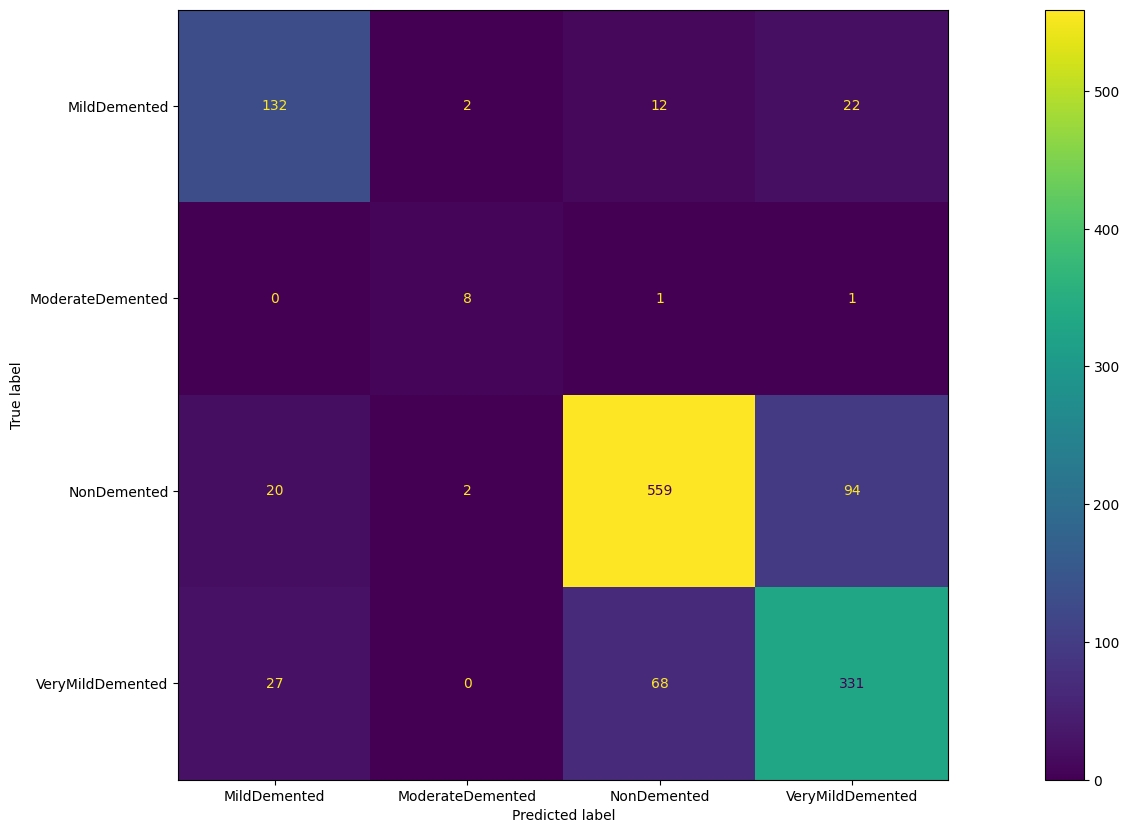

In [45]:
def visualize_model_prediction_result(classes, pred, labels, ax):
  confusion_matrix_data = confusion_matrix(y_true = labels, y_pred = pred)

  confusion_matrix_display = ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix_data,
    display_labels = classes,
  )

  confusion_matrix_display.plot(ax = ax)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (25, 10))

classification_report_result = classification_report(
    val_labels_array,
    val_outputs_array,
)

print(classification_report_result)

fpr, tpr, thresholds = roc_curve(val_labels_array, val_outputs_array, pos_label = 2)
print(f"AUC Score: {metrics.auc(fpr, tpr)}")

visualize_model_prediction_result(
    alzheimer_train_image_folders.classes, np.array(val_labels_array), np.array(val_outputs_array), ax
)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       715
           1       1.00      1.00      1.00        52
           2       1.00      1.00      1.00      2558
           3       1.00      1.00      1.00      1789

    accuracy                           1.00      5114
   macro avg       1.00      1.00      1.00      5114
weighted avg       1.00      1.00      1.00      5114

AUC Score: 0.3000782472613458


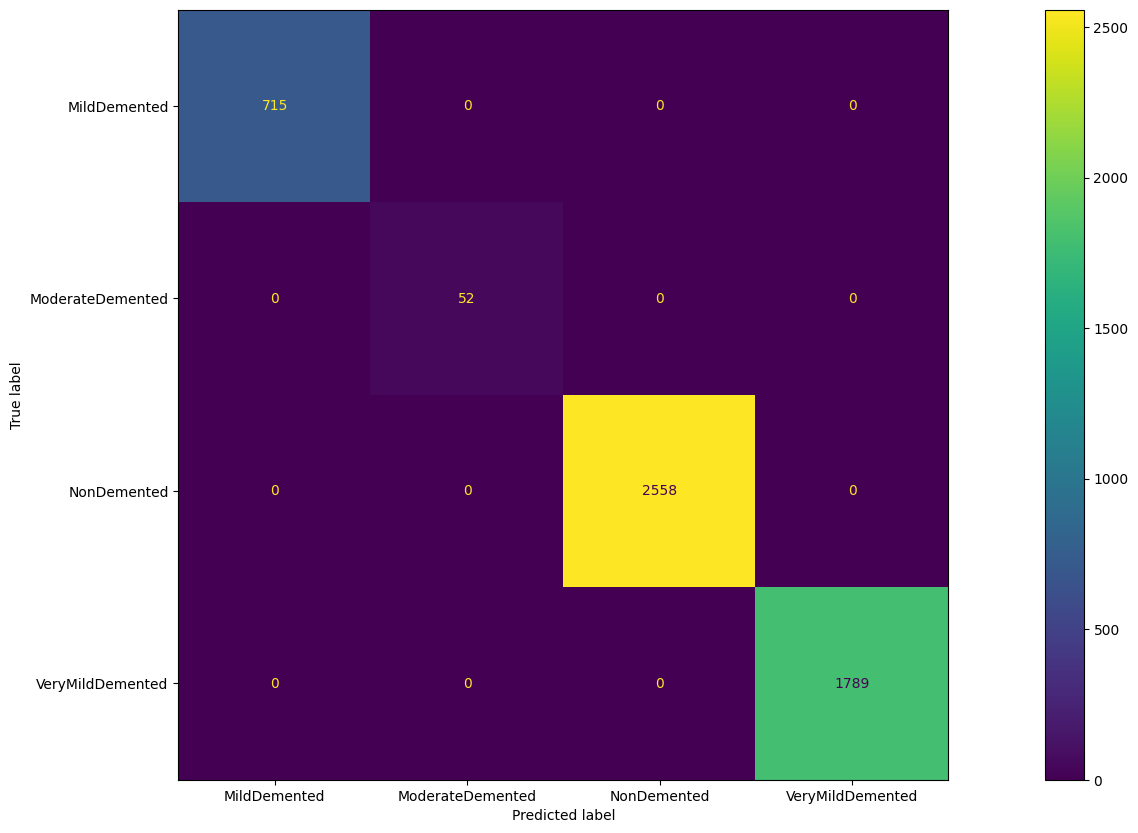

In [46]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (25, 10))

classification_report_result = classification_report(
    train_labels_array,
    train_outputs_array,
)

print(classification_report_result)

fpr, tpr, thresholds = roc_curve(train_labels_array, train_outputs_array, pos_label = 2)
print(f"AUC Score: {metrics.auc(fpr, tpr)}")

visualize_model_prediction_result(
    alzheimer_train_image_folders.classes, np.array(train_labels_array), np.array(train_outputs_array), ax
)